# Kurulumlar

In [ ]:
#!pip install wandb
#!pip install config

### Kütüphaneler

In [6]:
import tensorflow as tf
import os
import warnings
import time
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.cm as cm
from keras import backend as K
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential, model_from_json
from keras.datasets import cifar10
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras import layers,activations
from tensorflow import keras
from keras import regularizers
from keras import callbacks
from PIL import Image, ImageFilter, ImageStat
import random
random.seed(42)
import PIL
import itertools
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid


import warnings
warnings.filterwarnings("ignore")

# Veriyi Yükleme

In [7]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

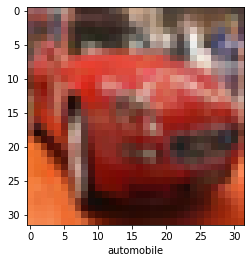

In [9]:
IMG_INDEX = 5
plt.imshow(train_images[IMG_INDEX] ,cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()

# Wandb ile Eğitim

In [10]:
import wandb
import config
from wandb.keras import WandbCallback

In [11]:
wandb.login()

wandb: Currently logged in as: yasarniyaz (use `wandb login --relogin` to force relogin)


True

In [12]:
sweep_config = {
    'method': 'grid', 
    'metric': {
      'name': 'accuracy', 
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [2,4]
        },
        'learning_rate': {
            'values': [0.01,0.001]
        },
        'optimizer': {
            'values': ['adam','rmsprop']
        },
        'activation': {
            'values': ['relu', 'elu', 'selu']
        }
    }
}

In [13]:
sweep_id=wandb.sweep(sweep_config,entity="yasarniyazoglu",project="yotube_keras")

Create sweep with ID: k3z3zwkw
Sweep URL: https://wandb.ai/yasarniyaz/yotube_keras/sweeps/k3z3zwkw


In [16]:
def train():
    config_defaults = {
        'epochs': 2,
        'batch_size': 128,
        'learning_rate': 0.001,
        'activation': 'relu',
        'optimizer': 'adam',
        'seed': 42
    }
    
    wandb.init(config=config_defaults)
    config=wandb.config
    
    model=Sequential()
    
    model.add(layers.Conv2D(filters=4,activation=config.activation,kernel_size=(3,3),input_shape=(32,32,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(filters=8,activation=config.activation,kernel_size=(3,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(filters=16,activation=config.activation,kernel_size=(3,3)))
    
    model.add(layers.Flatten())
    
    model.add(Dense(50,activation=config.activation))
    model.add(Dense(100,activation=config.activation))
    model.add(Dense(100,activation=config.activation))
    model.add(Dense(50,activation=config.activation))
    model.add(Dense(10,activation="softmax"))
    
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(loss=loss,optimizer=config.optimizer,metrics=["accuracy"])
    
    model.fit(train_images,train_labels,batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(test_images,test_labels),
              callbacks=[WandbCallback(data_type="image",validation_data=(test_images,test_labels))])

# Grid Search ile Train

In [ ]:
wandb.agent(sweep_id,train)